In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *
from soledge.wrapper_class import SOLEDGEcase

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = [ 
    # dict(name="1e19", id="d45a-d42acb_1e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19", id="d42acb-with_guards", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="3e19", id="d44a-d42acb_3e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="2e19_lores", id="t9b-nonortho_xpoint_afn", unnormalise_geom = True, use_xhermes = True, squash = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case d42acb-with_guards
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 10:49:23, dmp file date 09/03/2024, 10:28:10


c:\Users\mikek\pyenvs\fusion-3.12.11\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Read SOLEDGE

In [3]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    # "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    # "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    # "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    # "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    print(name)
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Make sure M is always positive
for region in ['inner_lower', 'outer_lower', 'outer_upper', 'inner_upper']:
    for name in soledgecases:
        sl[name].regions[region]["M"] = np.abs(sl[name].regions[region]["M"])


tightwall_1e19
tightwall_2e19
tightwall_3e19


# Read SOLPS

In [4]:
solpscases = {

    # "tightwall_noD2_1e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\From\Matteo\2024-11-01 - 1e19 2e19 3e19 no viscosity, spectra\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_spectra_20241106\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    "tightwall_noD2_1e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    
    "tightwall_noD2_1e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi_spectra\xxxx.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi_spectra\xxxx.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi_spectra\xxxx.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",

}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # _ = read_last10s(solpscases[name], save = True)
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [5]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    ds = cs[name].ds
    # ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    # ds = reverse_pfr_fluxes(ds)

2e19


# SOLPS radial -> poloidal interpolation

In [ ]:
ax.vlines

Text(0.5, 0, 'Distance from separatrix (m)')

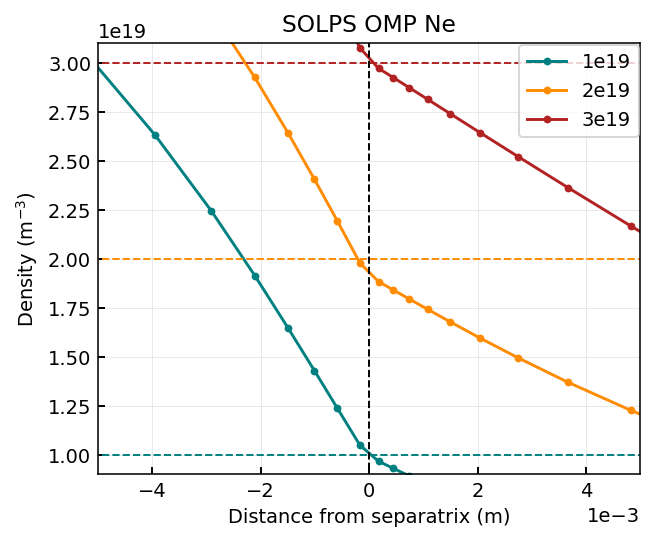

In [65]:


fig, ax = plt.subplots()
lw = 1

for i, dens in enumerate([1e19, 2e19, 3e19]):
    dens_string = f"{dens:.0e}".replace("+", "")
    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens_string}_zerophi_spectra"])
    df = spc.get_1d_radial_data(params = ["Ne"])
    
    ax.plot(df["dist"], df["Ne"], marker = "o", ms = 3, label = dens_string)

    xlims = ax.get_xlim()
    ax.hlines(dens, *xlims, colors = f"C{i}", lw = lw, ls = "--")
    ax.set_xlim(xlims)
    
ylims = ax.get_ylim()
ax.vlines(0, *ylims, colors = f"k", lw = lw, ls = "--")
ax.set_ylim(ylims)

ax.set_xlim(-0.005, 0.005)
ax.set_ylim(0.9e19, 3.1e19)
ax.legend()
ax.grid()
ax.set_title("SOLPS OMP Ne")
ax.set_ylabel("Density (m$^{-3}$)")
ax.set_xlabel("Distance from separatrix (m)")

# Hermes-3 Radial -> Poloidal interpolation

## Extending radial data getter to arbitrary index


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


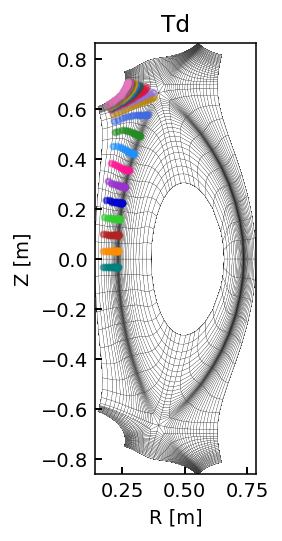

In [ ]:
ds = cs["2e19"].ds.isel(t=-1)

dist_from_sep = 0.001  # distance from separatrix
region = "inner_upper"
params = ["Te", "Td+"]
debug = True  # Plot radial slices

extra_params = ["R", "Z", "psi_poloidal", "dpol", "Bxy", "Bpxy"]
all_params = extra_params + params


m = ds.metadata

## This comes from _select_custom_sol_ring
start, end = _get_poloidal_range(ds, region)   

## Need to choose the psi we want based on an accurate midplane slice
if "outer" in region:
    start_region = "omp"
elif "inner" in region:
    start_region = "imp"
else:
    raise Exception("Region not recognised, needs to mention inner or outer")

midplane = get_1d_radial_data(ds, params = all_params, region = start_region, core = False)

# Exact psi at chosen separatrix distance
psi = scipy.interpolate.interp1d(midplane["Srad"], midplane["psi_poloidal"])(dist_from_sep)

df = pd.DataFrame()

fig, ax = plt.subplots()
for i in range(start,end):
    radial = get_1d_radial_data(ds, params = all_params, poloidal_index = i, core = False)
    
    if debug:
        ds["Td"].bout.polygon(ax = ax, grid_only = True, linecolor = "k", linewidth = 0.1, antialias = True, separatrix = False, add_colorbar = False)
        ax.plot(radial["R"], radial["Z"], "o", markersize = 3, alpha = 0.5)
    
    for param in all_params:
        df.loc[i, param] = scipy.interpolate.interp1d(radial["psi_poloidal"], radial[param])(psi)
        
df = df.reset_index(drop=True)

df["dpar"] = df["dpol"] * abs(df["Bxy"] / abs(df["Bpxy"]))  # Parallel cell width
df["Spol"] = df["dpol"].cumsum()   # Poloidal connection length
df["Spar"] = df["dpar"].cumsum()   # Parallel connection length


Text(0, 0.5, 'Td [eV]')

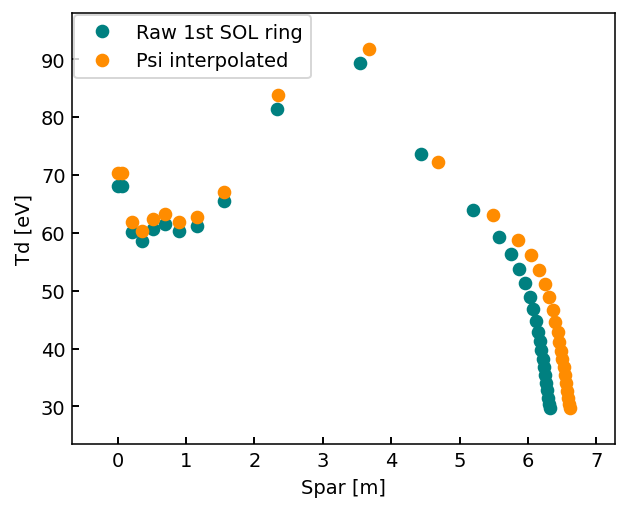

: 

In [ ]:
from hermes3.selectors import get_1d_poloidal_data

region = "inner_upper"
params = ["Ne", "Te", "Td+", "NVd", "Td"]

ds = cs["2e19"].ds.isel(t=-1)

fig, ax = plt.subplots()
df = get_1d_poloidal_data(ds, params = params, sepdist = 0.0005, region = "outer_lower", interpolate_radial = True)
df2 = get_1d_poloidal_data(ds, params = params, sepdist = 0.0005, interpolate_poloidal = False, region = "outer_lower")

ax.plot(df2["Spar"], df2["Td"], "o", label = "Raw 1st SOL ring")
ax.plot(df["Spar"], df["Td"], "o", label = "Psi interpolated")

ax.legend()
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Td [eV]")

In [ ]:

radials = []  # radial data slice
for i in range(start,end):
    radial = get_1d_radial_data(ds, params = ["R", "Z", "psi_poloidal"], poloidal_index = i, core = False)
    ax.plot(radial["R"], radial["Z"], "o")
    radials.append(radial)

<bound method Axes.legend of <Axes: >>

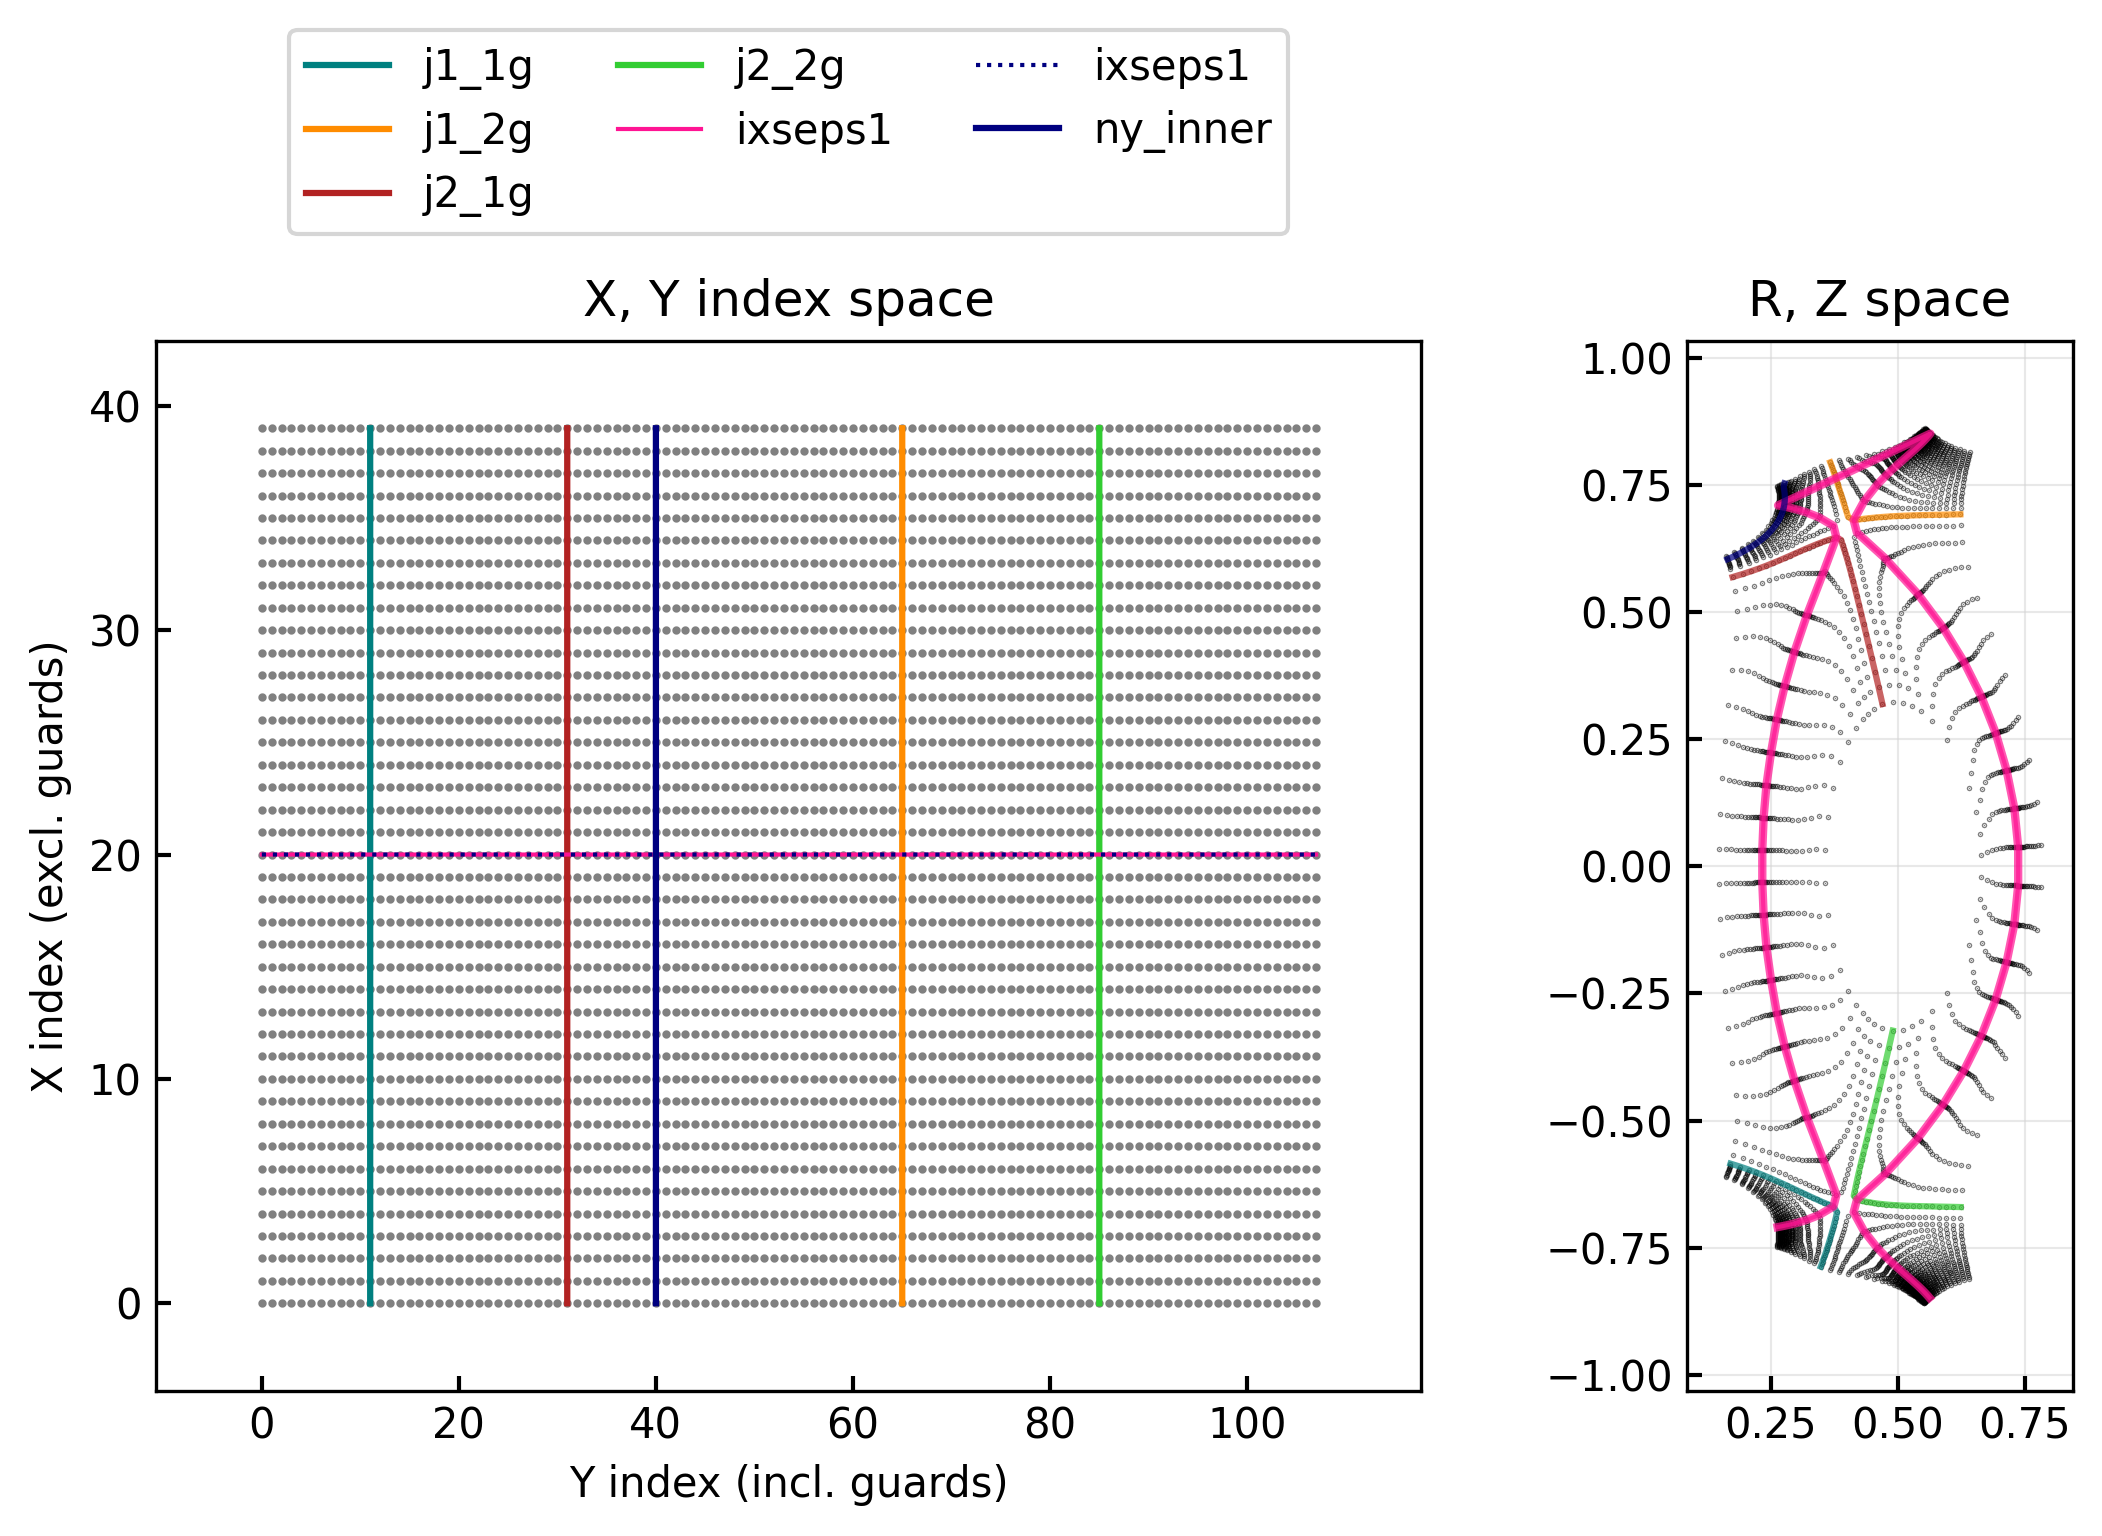

In [70]:
# Plot
fig, axes = plt.subplots(
    1,2, figsize=(8,5), dpi = 300, gridspec_kw={'width_ratios': [2, 1]},
    )
fig.subplots_adjust(
    wspace=0.15,
    top = 0.75, bottom = 0.05, left = 0.10, right = 0.95)

plot_xy_grid(ds, axes[0])
plot_rz_grid(ds, axes[1])

ax.legend

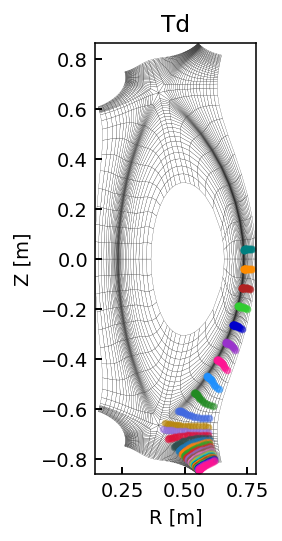

In [36]:
fig, ax = plt.subplots()
ds["Td"].bout.polygon(ax = ax, grid_only = True, linecolor = "k", linewidth = 0.1, antialias = True, separatrix = False, add_colorbar = False)
for radial in radials:
    ax.plot(radial["R"], radial["Z"], "o", markersize = 3, alpha = 0.5)

# Hermes-3 poloidal interpolation (increasing resolution) 

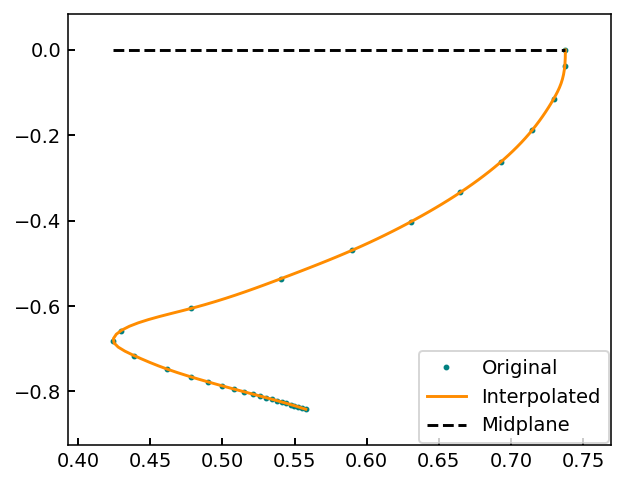

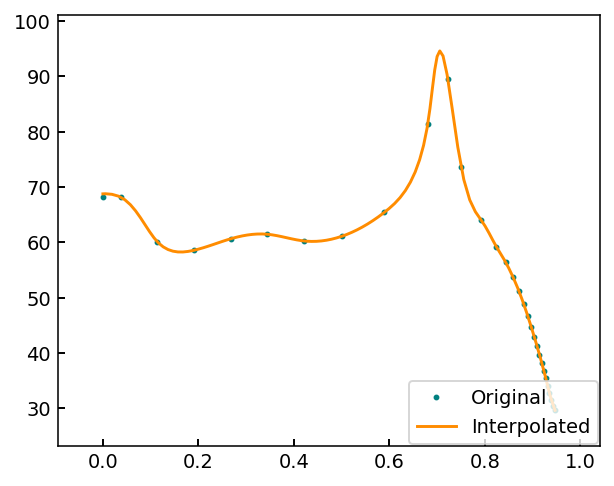

In [136]:
params = ["R", "Z", "Te", "Td"]
region = "outer_lower"
sepadd = 1
sepdist = None
interpolate = True
target_first = False

ds = cs["2e19"].ds.isel(t=-1)
fl = get_1d_poloidal_data(ds, params = params, region = region, sepadd = sepadd)
fl2 = get_1d_poloidal_data(ds, params = params, region = region, sepadd = sepadd, interpolate = True)

fig, ax = plt.subplots()
ax.plot(fl["R"], fl["Z"], marker = "o", ms = 2, lw = 0, label="Original")
ax.plot(fl2["R"], fl2["Z"], label="Interpolated", linestyle='-')
ax.hlines(0, fl["R"].min(), fl["R"].max(), color='k', linestyle='--', label="Midplane")
ax.legend(loc = "lower right")

fig, ax = plt.subplots()
ax.plot(fl["Spol"], fl["Td"], marker = "o", ms = 2, lw = 0, label="Original")
ax.plot(fl2["Spol"], fl2["Td"], label="Interpolated", linestyle='-')
# ax.hlines(0, fl["R"].min(), fl["R"].max(), color='k', linestyle='--', label="Midplane")
ax.legend(loc = "lower right")

# Interpolate 2D data onto it

Text(0, 0.5, 'Td')

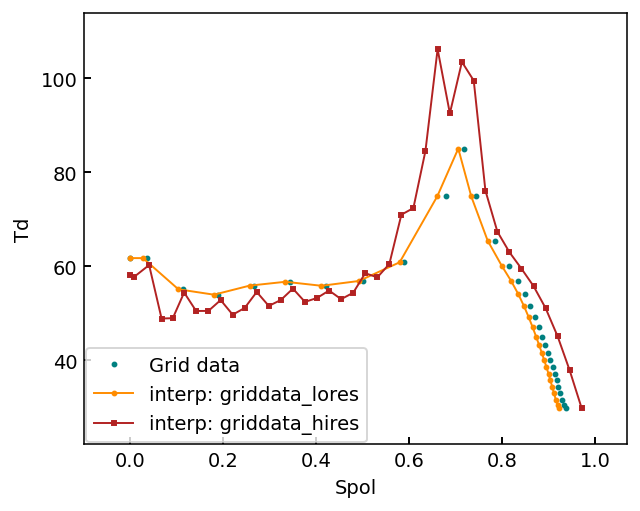

In [178]:
# def interpolate_2d(R, Z, data, )
params = ["R", "Z", "Te", "Td"]
region = "outer_lower"
sepadd = 2
sepdist = None
interpolate = True
target_first = False


ds = cs["2e19"].ds.isel(t=-1)
fl = get_1d_poloidal_data(ds, params = params, region = region, sepadd = sepadd)
fl2 = get_1d_poloidal_data(ds, params = params, region = region, sepadd = sepadd, interpolate = True, interpolate_resolution = 40)



def interpolate_fieldline_from_2d(ds, R, Z, params,
                        method = "griddata_linear"):
    """
    Interpolates the given parameters from a 2D dataset onto the specified R and Z coordinates.
    Uses scipy's griddata for interpolation.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset containing the 2D grid data.
    R : np.ndarray
        The radial coordinates where the data should be interpolated.
    Z : np.ndarray
        The vertical coordinates where the data should be interpolated.
    params : list of str
        The parameters to interpolate from the dataset.
    """
    df = pd.DataFrame()
    df["R"] = R
    df["Z"] = Z
    R_grid = ds["R"].values
    Z_grid = ds["Z"].values
    points = np.column_stack((R_grid.ravel(), Z_grid.ravel()))

    for param in ["Bxy", "Bpxy", "dpol"] + params:
        data = ds[param].values
        query_points = np.column_stack((R, Z))
        
        if method == "griddata_linear":
            df[param] = scipy.interpolate.griddata(points, data.ravel(), query_points, method="linear")
        elif method == "griddata_nearest":
            df[param] = scipy.interpolate.griddata(points, data.ravel(), query_points, method="nearest")
        elif method == "CloughTocher":
            cti = scipy.interpolate.CloughTocher2DInterpolator(points, data.ravel())
            df[param] = cti(R, Z)
        elif method == "linear":
            df[param] = scipy.interpolate.LinearNDInterpolator(points, data.ravel(), query_points)
        else:
            raise ValueError(f"Unknown interpolation method: {method}")
        
    # Get distances
    dR = np.gradient(df["R"])
    dZ = np.gradient(df["Z"])

    dpol = np.sqrt(dR**2 + dZ**2)
    # Account for the fact that first point is at OMP and second is halfway through a cell
    dpol[0] = 0
    dpol[1] /= 2
    dpar = dpol * abs(df["Bxy"]) / abs(df["Bpxy"])
    df["Spol"] = dpol.cumsum()
    df["Spar"] = dpar.cumsum()
    
    return df

# fl2 is high res.

tests = {
    "griddata_lores" :           interpolate_fieldline_from_2d(ds, fl["R"], fl["Z"], ["Td"], method = "griddata_linear"),
    # "griddata_nearest" :       interpolate_fieldline_from_2d(ds, fl["R"], fl["Z"], ["Td"], method = "griddata_nearest"),
    # "griddata_nearest_hires" : interpolate_fieldline_from_2d(ds, fl2["R"], fl2["Z"], ["Td"], method = "griddata_nearest"),
    "griddata_hires" :         interpolate_fieldline_from_2d(ds, fl2["R"], fl2["Z"], ["Td"], method = "griddata_linear"),
    # "CloughTocher_lores" :     interpolate_fieldline_from_2d(ds, fl["R"], fl["Z"], ["Td"], method = "CloughTocher"),
    # "CloughTocher_hires" :     interpolate_fieldline_from_2d(ds, fl2["R"], fl2["Z"], ["Td"], method = "CloughTocher"),
    # "linear_hires" :           interpolate_fieldline_from_2d(ds, fl2["R"], fl2["Z"], ["Td"], method = "linear"),
}

fig, ax = plt.subplots()
xtype = "Spol"
param = "Td"
ax.plot(fl[xtype], fl[param], marker = "o", ms = 2, lw = 0, label="Grid data")
# ax.plot(fl2[xtype], fl2[param], label="1D hi res interp", linestyle='-')

markers = ["o", "s", "D", "x", "v", "^", "<", ">"]

for i, name in enumerate(tests.keys()):
    df = tests[name]
    marker = markers[i]
    ax.plot(df[xtype], df[param], label=f"interp: {name}", linestyle='-', lw = 1, marker = markers[i], ms = 2)
    # ax.plot(df["R"], df[param], label=f"interp: {name}", linestyle='-', lw = 1, marker = markers[i], ms = 2)
# ax.hlines(0, fl["R"].min(), fl["R"].max(), color='k', linestyle='--', label="Midplane")
ax.legend(loc = "lower left")
ax.set_xlabel(xtype)
ax.set_ylabel(param)

# Interpolate on same points correctly
Works! 
dpol can't be calculated from RZ trigonometry.

Text(0, 0.5, 'Td')

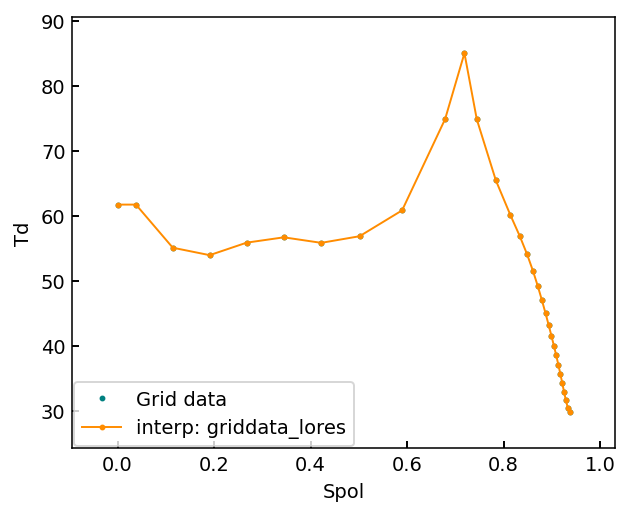

In [148]:
# def interpolate_2d(R, Z, data, )
params = ["Td"]
region = "outer_lower"
sepadd = 2
sepdist = None
interpolate = True
target_first = False

ds = cs["2e19"].ds.isel(t=-1)

# Lores
fl = get_1d_poloidal_data(ds, params = params+["R", "Z", "dpol", "hthe"], region = region, sepadd = sepadd)


df = pd.DataFrame()

df["Spol"] = fl["Spol"].copy()
df["Spar"] = fl["Spar"].copy()
df["R_query"] = fl["R"].copy()
df["Z_query"] = fl["Z"].copy()
df["dpol_original"] = fl["dpol"].copy()
dR = df["R_query"].diff().fillna(0)
dZ = df["Z_query"].diff().fillna(0)
df["dpol_triang"] = np.sqrt(dR**2 + dZ**2)
df["dpol_ratio"] = df["dpol_original"] / df["dpol_triang"]

R_grid = ds["R"].values
Z_grid = ds["Z"].values
points = np.column_stack((R_grid.ravel(), Z_grid.ravel()))

for param in ["R", "Z", "Bxy", "Bpxy", "dpol"] + params:
    data = ds[param].values
    query_points = np.column_stack((df["R_query"], df["Z_query"]))
    
    df[f"{param}_interp"] = scipy.interpolate.griddata(points, data.ravel(), query_points, method="linear")

# Account for the fact that first point is at OMP and second is halfway through a cell
df["dpol_interp"].iloc[0] = 0
df["dpol_interp"].iloc[1] /= 2
df["Spol_interp"] = df["dpol_interp"].cumsum()

dpar = df["dpol_interp"] * abs(df["Bxy_interp"]) / abs(df["Bpxy_interp"])
df["Spar_interp"] = dpar.cumsum()


fig, ax = plt.subplots()
xtype = "Spol"
param = "Td"
ax.plot(fl[xtype], fl[f"{param}"], marker = "o", ms = 2, lw = 0, label="Grid data")

ax.plot(df[f"{xtype}_interp"], df[f"{param}_interp"], label=f"interp: {name}", linestyle='-', lw = 1, marker = "o", ms = 2)
ax.legend(loc = "lower left")
ax.set_xlabel(xtype)
ax.set_ylabel(param)

## Interpolate on finer points

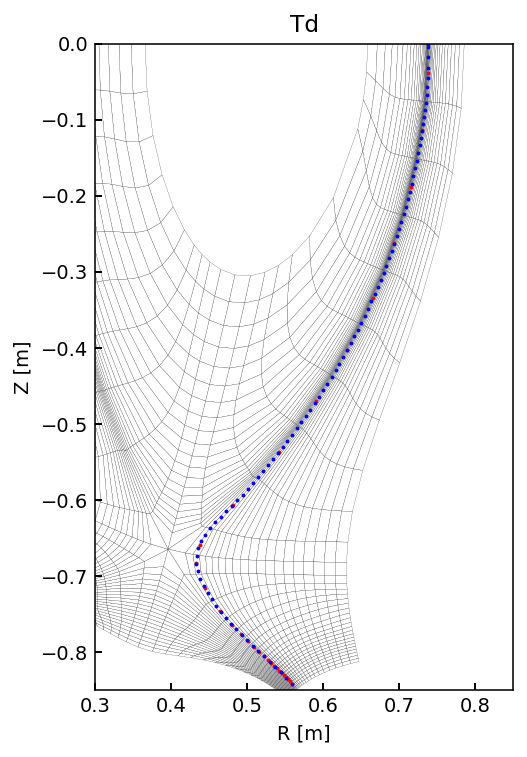

In [163]:
fl = get_1d_poloidal_data(ds, params = params+["R", "Z", "dpol", "hthe"], region = region, sepadd = sepadd)
fl_hires = get_1d_poloidal_data(ds, params = params+["R", "Z", "dpol", "hthe"], region = region, sepadd = sepadd, interpolate = True)

fig, ax = plt.subplots(figsize = (6,6))

ds["Td"].bout.polygon(ax = ax, grid_only = True, linecolor = "k", linewidth = 0.1, antialias = True, separatrix = False, add_colorbar = False)
ax.set_xlim(0.3, 0.85)
ax.set_ylim(-0.85, 0)

ax.plot(fl["R"], fl["Z"], "o", c = "r", ms = 1, label = "Low resolution")
ax.plot(fl_hires["R"], fl_hires["Z"], "o", c = "b", ms = 1, label = "High resolution")


In [ ]:
# def interpolate_2d(R, Z, data, )
params = ["Td"]
region = "outer_lower"
sepadd = 2
sepdist = None
interpolate = True
target_first = False

ds = cs["2e19"].ds.isel(t=-1)

# Lores
fl = get_1d_poloidal_data(ds, params = params+["R", "Z", "dpol", "hthe"], region = region, sepadd = sepadd)
fl_hires = get_1d_poloidal_data(ds, params = params+["R", "Z", "dpol", "hthe"], region = region, sepadd = sepadd, interpolate = True)

df = pd.DataFrame()

df["R_query"] = fl["R"].copy()
df["Z_query"] = fl["Z"].copy()
df["dpol_original"] = fl["dpol"].copy()


R_grid = ds["R"].values
Z_grid = ds["Z"].values
points = np.column_stack((R_grid.ravel(), Z_grid.ravel()))

for param in ["R", "Z", "Bxy", "Bpxy", "dpol"] + params:
    data = ds[param].values
    query_points = np.column_stack((df["R_query"], df["Z_query"]))
    
    df[f"{param}_interp"] = scipy.interpolate.griddata(points, data.ravel(), query_points, method="linear")

dR_query = df["R_query"].diff().fillna(0)
dZ_query = df["Z_query"].diff().fillna(0)
df["dpol"] = np.sqrt(dR_query**2 + dZ_query**2)


# Account for the fact that first point is at OMP and second is halfway through a cell
df["dpol_interp"].iloc[0] = 0
df["dpol_interp"].iloc[1] /= 2
df["Spol_interp"] = df["dpol_interp"].cumsum()

dpar = df["dpol_interp"] * abs(df["Bxy_interp"]) / abs(df["Bpxy_interp"])
df["Spar_interp"] = dpar.cumsum()


fig, ax = plt.subplots()
xtype = "Spol"
param = "Td"
ax.plot(fl[xtype], fl[f"{param}"], marker = "o", ms = 2, lw = 0, label="Grid data")

ax.plot(df[f"{xtype}_interp"], df[f"{param}_interp"], label=f"interp: {name}", linestyle='-', lw = 1, marker = "o", ms = 2)
ax.legend(loc = "lower left")
ax.set_xlabel(xtype)
ax.set_ylabel(param)

## Check fit

Text(0, 0.5, 'Td')

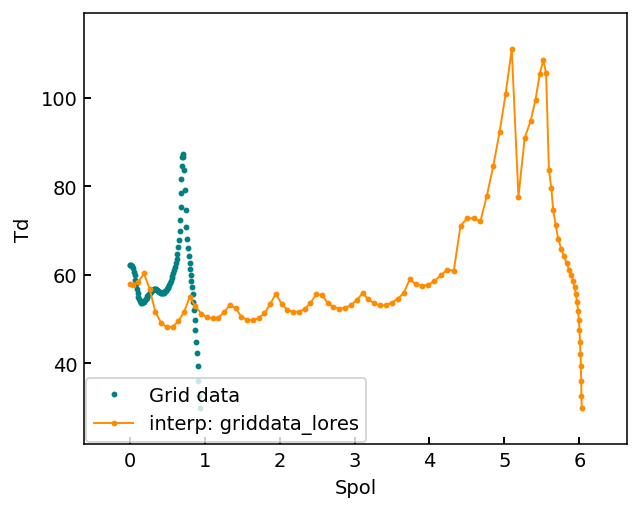

## Check Spol

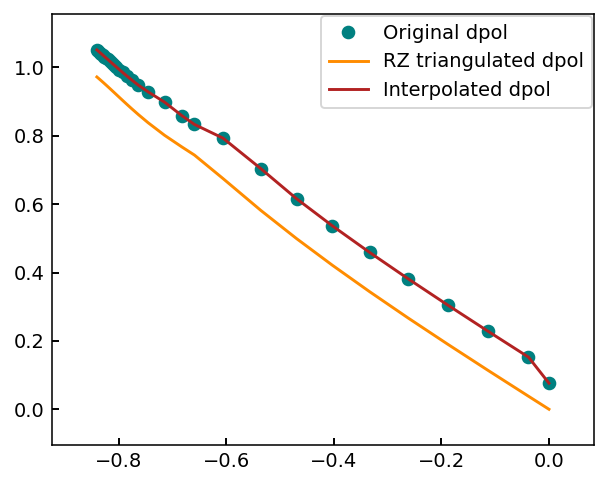

In [71]:
fig, ax = plt.subplots()
x_choice = "Z_query"
ax.plot(df[x_choice], df["dpol_original"].cumsum(), "o",  label = "Original dpol")
ax.plot(df[x_choice], df["dpol_triang"].cumsum(), label = "RZ triangulated dpol")
ax.plot(df[x_choice], df["dpol_interp"].cumsum(), label = "Interpolated dpol")
ax.legend()

## Check dpol

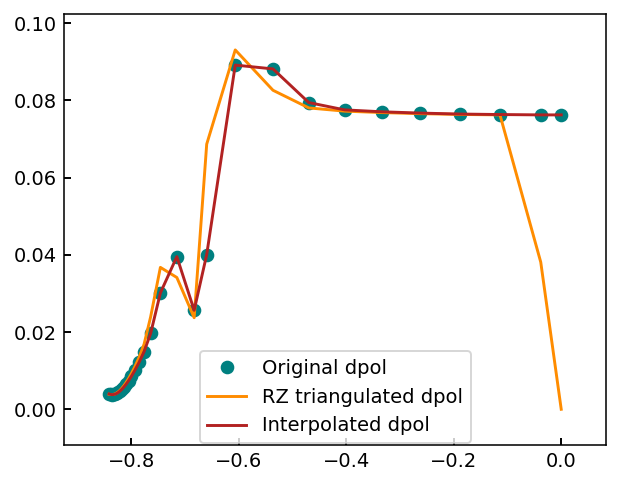

In [91]:
fig, ax = plt.subplots()
x_choice = "Z_query"
ax.plot(df[x_choice], df["dpol_original"], "o",  label = "Original dpol")
ax.plot(df[x_choice], df["dpol_triang"], label = "RZ triangulated dpol")
ax.plot(df[x_choice], df["dpol_interp"], label = "Interpolated dpol")
ax.legend()

Text(0, 0.5, 'Td')

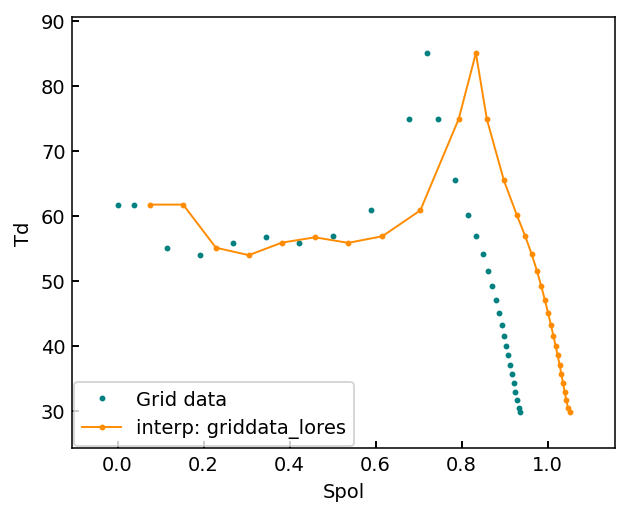

In [ ]:
df = pd.DataFrame()
df["R"] = R
df["Z"] = Z
R_grid = ds["R"].values
Z_grid = ds["Z"].values
points = np.column_stack((R_grid.ravel(), Z_grid.ravel()))

for param in ["Bxy", "Bpxy"] + params:
    data = ds[param].values
    query_points = np.column_stack((R, Z))
    
    if method == "griddata_linear":
        df[param] = scipy.interpolate.griddata(points, data.ravel(), query_points, method="linear")
    elif method == "griddata_nearest":
        df[param] = scipy.interpolate.griddata(points, data.ravel(), query_points, method="nearest")
    elif method == "CloughTocher":
        cti = scipy.interpolate.CloughTocher2DInterpolator(points, data.ravel())
        df[param] = cti(R, Z)
    elif method == "linear":
        df[param] = scipy.interpolate.LinearNDInterpolator(points, data.ravel(), query_points)
    else:
        raise ValueError(f"Unknown interpolation method: {method}")

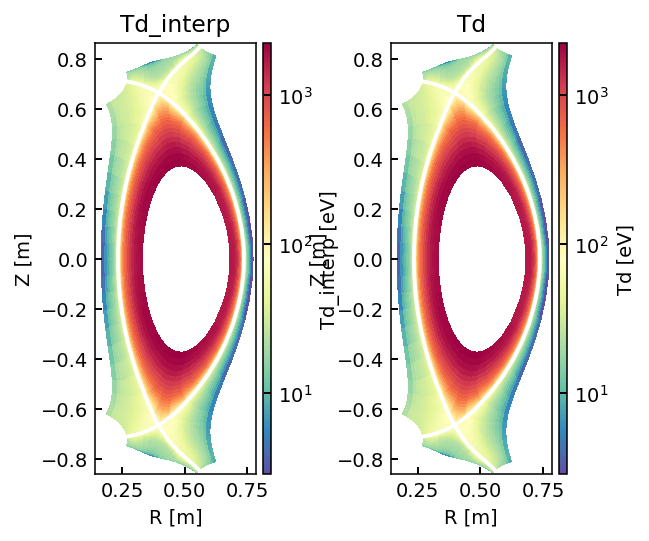

In [25]:
R_grid = ds["R"].values
Z_grid = ds["Z"].values
points = np.column_stack((R_grid.ravel(), Z_grid.ravel()))
data = ds["Td"].values

query_points = points

Td_interp = scipy.interpolate.griddata(points, data.ravel(), query_points, method="linear")

Td_interp = Td_interp.reshape(R_grid.shape)

ds["Td_interp"] = xr.DataArray(
    data = Td_interp,
    coords = ds["Td"].coords,
    dims = ds["Td"].dims,
    attrs = ds["Td"].attrs,
    name = "Td_interp"
)

fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.set_title("Interpolated Td")
ds["Td_interp"].hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", logscale = True)
ax = axes[1]
ax.set_title("Original Td")
ds["Td"].hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", logscale = True)

# Investigate X-point centroid
- Ok, so what's going on is that the reported cell centres are valid for the actual psi,theta centres, so centres of the actual cell shapes.
- The grid we usually plot is a crude approximation of the cells, because it only has the corners. The centre of the corners will therefore not be accurate.

Text(0.5, 1.0, '')

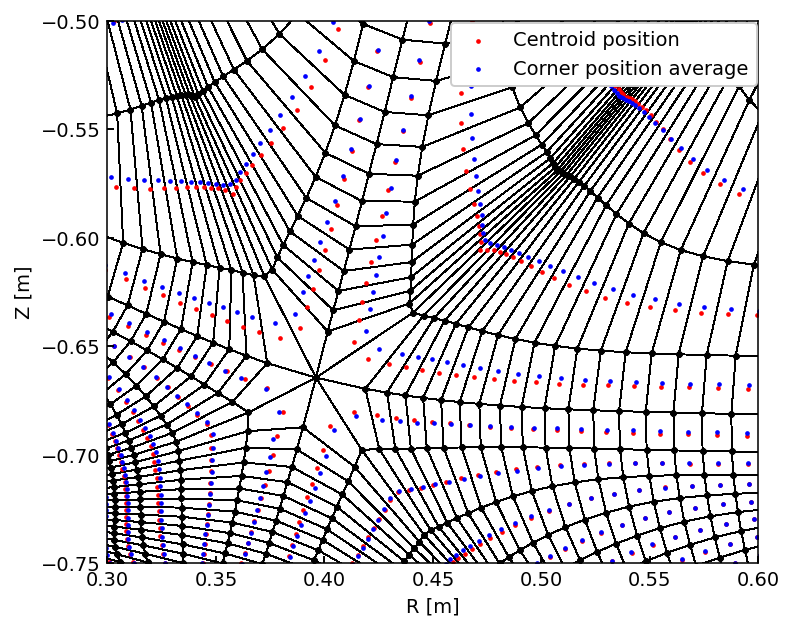

In [147]:
fig, ax = plt.subplots(figsize = (6,6))

ds["Td"].bout.polygon(ax = ax, grid_only = True, linecolor = "k", linewidth = 0.5, separatrix = False, add_colorbar = False)


ax.scatter(ds["R"], ds["Z"], s= 2, c = "red", label = "Centroid position")

for i, side in enumerate(["lower_left", "lower_right", "upper_left", "upper_right"]):
    ax.scatter(ds[f"Rxy_{side}_corners"], ds[f"Zxy_{side}_corners"], s= 5, color = "black")

    if i == 0:
        R_mean = ds[f"Rxy_{side}_corners"].copy().values
        Z_mean = ds[f"Zxy_{side}_corners"].copy().values
    else:
        R_mean += ds[f"Rxy_{side}_corners"].copy().values
        Z_mean += ds[f"Zxy_{side}_corners"].copy().values
        
R_mean /= 4
Z_mean /= 4

ax.scatter(R_mean, Z_mean, s= 2, c = "blue", label = "Corner position average")


ax.set_aspect("equal")
ax.set_xlim(0.3, 0.6)
ax.set_ylim(-0.75, -0.5)
ax.legend(loc = "upper right", framealpha = 1)
ax.set_title("")

In [110]:
[print(x) for x in ds.coords if "corners" in x]

Rxy_lower_left_corners
Rxy_lower_right_corners
Rxy_upper_left_corners
Rxy_upper_right_corners
Zxy_lower_left_corners
Zxy_lower_right_corners
Zxy_upper_left_corners
Zxy_upper_right_corners


[None, None, None, None, None, None, None, None]

In [ ]:
fig, ax = plt.subplots()
param = "Td"
ax.plot(fl[""])

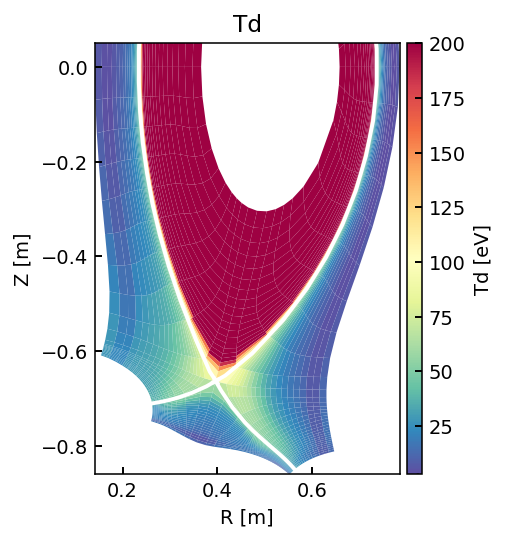

In [52]:
fig, ax = plt.subplots()
ds["Td"].bout.polygon(ax = ax, cmap = "Spectral_r", vmax = 200, antialias = True)
ax.set_ylim(None,0.05)

plt.scatter(R_query, Z_query, c=interpolated_values, edgecolor='k')

In [8]:
plt.tricontourf(R.ravel(), Z.ravel(), data.ravel(), levels=50)
plt.scatter(R_query, Z_query, c=interpolated_values, edgecolor='k')
plt.colorbar()
plt.xlabel("R")
plt.ylabel("Z")
plt.axis("equal")

NameError: name 'R' is not defined